In [217]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, log_loss, accuracy_score

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Conv2D,MaxPooling2D,Activation,Dropout

from art.utils import load_dataset

In [218]:
lfw_dataset=fetch_lfw_people(min_faces_per_person=100)

In [219]:
print(lfw_dataset.images.shape)
print(lfw_dataset.data.shape)
print(lfw_dataset.target_names.shape)
print(lfw_dataset.target.shape)

(1140, 62, 47)
(1140, 2914)
(5,)
(1140,)


In [222]:
X0=lfw_dataset.images
y=lfw_dataset.target
X=X0.reshape(-1,62,47,1)

trainx,testx,trainy,testy=train_test_split(X,to_categorical(y),test_size=0.2)

print(trainx.shape)
print(testx.shape)
print(trainy.shape)
print(testy.shape)

(912, 62, 47, 1)
(228, 62, 47, 1)
(912, 5)
(228, 5)


In [223]:
testy[0]

array([0., 0., 1., 0., 0.], dtype=float32)

In [224]:
x_train = trainx.astype(np.float32)
x_test = testx.astype(np.float32)
y_train = trainy.astype(np.float32)
y_test = testy.astype(np.float32)

In [240]:
from art.attacks.evasion import FeatureAdversariesTensorFlowV2
from art.estimators.classification import TensorFlowV2Classifier
from art.utils import load_mnist

model = Sequential()
model.add(Conv2D(32,(3,3), input_shape=(62,47,1), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32,(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=5, activation='softmax'))
# model.summary()
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Step 2a: Define the loss function and optimizer

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

def train_step(model, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# Step 3: Create the ART classifier

classifier = TensorFlowV2Classifier(
    model=model,
    loss_object=loss_object,
    train_step=train_step,
    nb_classes=5,
    input_shape=(62, 47, 1),
    clip_values=(0, 1),
)

In [241]:
classifier.fit(x_train, y_train, validation_data=(x_test, y_test), nb_epochs=100)

In [231]:
classifier.predict(x_train)

array([[0.20671345, 0.09626867, 0.48791662, 0.08586582, 0.12323547],
       [0.20671345, 0.09626867, 0.48791662, 0.08586582, 0.12323547],
       [0.20671345, 0.09626867, 0.48791662, 0.08586582, 0.12323547],
       ...,
       [0.20671345, 0.09626867, 0.48791662, 0.08586582, 0.12323547],
       [0.20671345, 0.09626867, 0.48791662, 0.08586582, 0.12323547],
       [0.20671345, 0.09626867, 0.48791662, 0.08586582, 0.12323547]],
      dtype=float32)

In [234]:
# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 43.42105263157895%


In [247]:
# Step 5: prepare a batch of source and guide images
valid = np.argmax(y_test, axis=1)[:100] != np.argmax(y_test, axis=1)[100:200]
source = x_test[:100][valid][:32]
guide = x_test[100:200][valid][:32]

In [249]:
y_test.shape

(228, 5)

In [242]:
# Step 6: Generate adversarial test examples
attack = FeatureAdversariesTensorFlowV2(
    classifier,
    layer=-2,
    delta=45/255,
    optimizer=None,
    step_size=1/255,
    max_iter=100,
)
x_test_adv = attack.generate(source, guide)

# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:100][valid][:32], axis=1)) / len(y_test[:100][valid][:32])

dim = tuple(range(1, len(source.shape)))
pert = np.mean(np.amax(np.abs(source - x_test_adv), axis=dim))
print("Accuracy on adversarial test batch: {}%".format(accuracy * 100))
print("Average perturbation: {}%".format(pert))

Feature Adversaries TensorFlow v2:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test batch: 56.25%
Average perturbation: 228.98959350585938%


In [243]:
x_test_adv.shape

(32, 62, 47, 1)

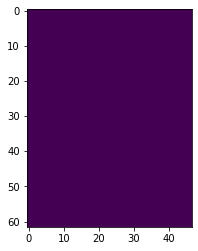

In [244]:
# Step 8: Inspect results

# orig 7, guide 6
plt.imshow(x_test_adv[2,...].squeeze())

In [245]:
# Step 6: Generate adversarial test examples
attack = FeatureAdversariesTensorFlowV2(
    classifier,
    layer=-2,
    delta=45/255,
    optimizer=tf.keras.optimizers.Adam,
    optimizer_kwargs={"learning_rate": 0.01},
    lambda_=1.0,
    max_iter=100,
    random_start=True,
)
x_test_adv = attack.generate(source, guide)

# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:100][valid][:32], axis=1)) / len(y_test[:100][valid][:32])

dim = tuple(range(1, len(source.shape)))
pert = np.mean(np.amax(np.abs(source - x_test_adv), axis=dim))
print("Accuracy on adversarial test batch: {}%".format(accuracy * 100))
print("Average perturbation: {}%".format(pert))

Feature Adversaries TensorFlow v2:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test batch: 56.25%
Average perturbation: 228.98959350585938%


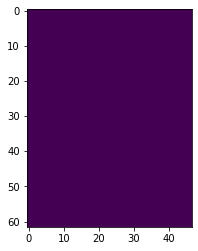

In [246]:
# orig 1, guide 5
plt.imshow(x_test_adv[10,...].squeeze())

In [213]:
def plot_gallery(images, titles, h=62, w=47, n_row=1, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i+1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

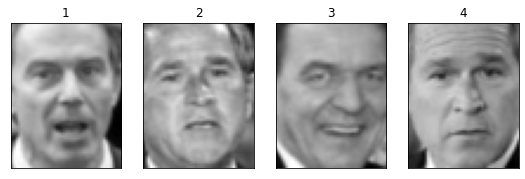

In [214]:
test1=x_test[0:4].reshape(4,62*47)
plot_gallery(test1,'1234',62,47)

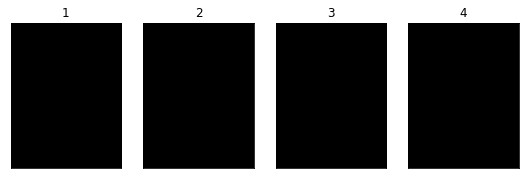

In [216]:
test1_adv=x_test_adv[0:4].reshape(4,62*47)
plot_gallery(test1_adv,'1234',62,47)